In [1]:
# General
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import graphviz
import time
import os

# Sklearn
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import export_graphviz, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Tensorflow/Keras
import tensorflow as tf

# Load Data

In [ ]:
# Load data
train_df = pd.read_csv("../processed_data/train_df.csv")
train_df['DATE_TIME']= pd.to_datetime(train_df['DATE_TIME'],format='%Y-%m-%d %H:%M:%S')

# These were exported to train_df.csv
#train_df["HOUR"] = train_df['DATE_TIME'].dt.hour
#train_df.dropna(inplace=True)
#train_df.reset_index(drop=True, inplace=True)

test_df = pd.read_csv("../processed_data/test_df.csv")
test_df['DATE_TIME']= pd.to_datetime(test_df['DATE_TIME'],format='%Y-%m-%d %H:%M:%S')

# These were exported to test_df.csv
#test_df["HOUR"] = test_df['DATE_TIME'].dt.hour
#test_df.dropna(inplace=True)
#test_df.reset_index(drop=True, inplace=True)

mae_results = {}
rmse_results = {}

#### Function that scaled DC_POWER of plant 1 down by 10. New values were exported to train_df.csv and test_df.csv.

In [87]:
# def scale_down_plant_1(df):
#     for i in df.index:
#         if(df.iloc[i].PLANT_ID == 4135001):
#             df.loc[i,'DC_POWER'] = df.iloc[i].DC_POWER/10
            
# scale_down_plant_1(train_df)
# scale_down_plant_1(test_df)

# train_df.to_csv("../processed_data/train_df.csv", index=False)
# test_df.to_csv("../processed_data/test_df.csv", index=False)

In [88]:
def calculate_metrics(label, true, pred):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    mae_results[label] = mae
    rmse_results[label] = rmse
    print(label + " MAE: " + str(mae) + " kW.")
    print(label + " RMSE: " + str(rmse) + " kW.")
    
def plot_true_vs_pred(label, true, pred):
    x_ax = range(len(true))
    plt.plot(x_ax, true, label="original")
    plt.plot(x_ax, pred, label="predicted")
    plt.title("Test and Predicted Data " + label)
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend(loc='best',fancybox=True, shadow=True)
    plt.grid(True)
    plt.show() 

# Baseline Predictor

#### Baseline predictor predicts the average train AC power for everything.

In [89]:
# normalize
normnames = ['DC_POWER','AC_POWER','DAILY_YIELD','TOTAL_YIELD','AMBIENT_TEMPERATURE','MODULE_TEMPERATURE','IRRADIATION']

import copy
train_df_norm = copy.deepcopy(train_df)
test_df_norm = copy.deepcopy(test_df)

for col in normnames:
    train_df_norm[col]=(train_df_norm[col]-train_df_norm[col].min())/(train_df_norm[col].max()-train_df_norm[col].min())
    test_df_norm[col]=(test_df_norm[col]-test_df_norm[col].min())/(test_df_norm[col].max()-test_df_norm[col].min())


In [94]:
baseline_train_y = train_df_norm.AC_POWER
baseline_test_y = test_df_norm.AC_POWER

baseline = baseline_train_y.mean()
calculate_metrics("Baseline", baseline_test_y, [baseline]*len(baseline_test_y))

Baseline MAE: 0.20538091149968826 kW.
Baseline RMSE: 0.23398530781270435 kW.


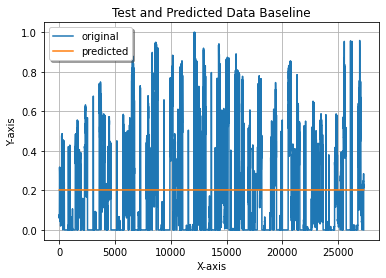

In [95]:
plot_true_vs_pred("Baseline", baseline_test_y, [baseline]*len(baseline_test_y))

# Linear Regression 1

#### Linear regression predictor. Grid search cross validation.

In [96]:
# 'TIME' performs better than 'HOUR' in this case
lr_features = ["PLANT_ID", "SOURCE_KEY", "AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE", "IRRADIATION", "TIME"]

# Train data
lr_train_x = train_df_norm[lr_features]
lr_train_y = train_df_norm.AC_POWER

lr_train_x.PLANT_ID = lr_train_x.PLANT_ID.astype("category")
lr_train_x = pd.get_dummies(lr_train_x)

/var/folders/ks/_m3rj8jd5qscrftnn0qmdk4w0000gn/T/ipykernel_69958/1056408368.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lr_train_x.PLANT_ID = lr_train_x.PLANT_ID.astype("category")


In [ ]:
# # normalize
# import copy
# train_df_normed = copy.deepcopy(train_df)
# test_df_normed = copy.deepcopy(test_df)


# for col in lr_features[2:4]:
#     train_df_normed[col]=(train_df_normed[col]-train_df_normed[col].min())/(train_df_normed[col].max()-train_df_normed[col].min())

# lr_train_y_normalized=(lr_train_y_normalized-lr_train_y_normalized.min())/(lr_train_y_normalized.max()-lr_train_y_normalized.min())


#### Set features and targets

In [102]:
# Test data
lr_test_x = test_df_norm[lr_features]
lr_test_y = test_df.AC_POWER

lr_test_x.PLANT_ID = lr_test_x.PLANT_ID.astype("category")
lr_test_x = pd.get_dummies(lr_test_x)


/var/folders/ks/_m3rj8jd5qscrftnn0qmdk4w0000gn/T/ipykernel_69958/694443211.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lr_test_x.PLANT_ID = lr_test_x.PLANT_ID.astype("category")


In [103]:
lr1_parameters = {'fit_intercept':[True,False], 'copy_X':[True, False]}

lr_1 = GridSearchCV(LinearRegression(), lr1_parameters, scoring='neg_mean_squared_error', n_jobs=-1)
lr_1.fit(lr_train_x, lr_train_y)

print("Linear regression parameters: ", lr_1.best_params_)

/Users/gchi/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/gchi/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/gchi/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/gchi/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 261, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/Users/gchi/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 71, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/Users/gchi/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_base.py", line 386, in predict
    return

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [9]:
lr_1_preds = lr_1.predict(lr_test_x)
calculate_metrics("Linear Regression 1", lr_test_y, lr_1_preds)

Linear Regression 1 MAE: 78.70071997165569 kW.
Linear Regression 1 RMSE: 138.33957612746275 kW.


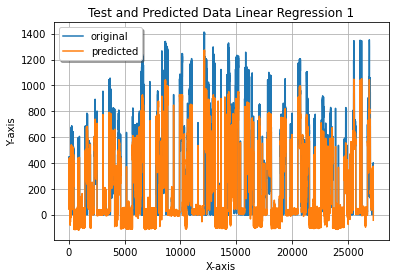

In [10]:
plot_true_vs_pred("Linear Regression 1", lr_test_y, lr_1_preds)

# Linear Regression 2 (Ridge)

#### Linear regression with ridge regularization. Grid search cross validation.

In [11]:
lr_reg_parameters = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}

lr_2 = GridSearchCV(Ridge(), lr_reg_parameters, return_train_score=True, scoring='neg_mean_squared_error', n_jobs=-1)
lr_2.fit(lr_train_x, lr_train_y)

print("Linear regression 2 (Ridge) parameters: ", lr_2.best_params_)

Linear regression 2 (Ridge) parameters:  {'alpha': 100}


In [12]:
lr_2_preds = lr_2.predict(lr_test_x)
calculate_metrics("Linear Regression Ridge", lr_test_y, lr_2_preds)

Linear Regression Ridge MAE: 78.93752004693509 kW.
Linear Regression Ridge RMSE: 138.37228791034553 kW.


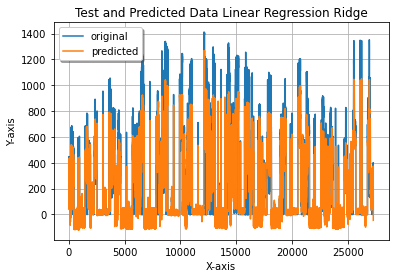

In [13]:
plot_true_vs_pred("Linear Regression Ridge", lr_test_y, lr_2_preds)

# Linear Regression 3 (Lasso)

#### Linear regression with lasso regularization. Grid search cross validation.

In [14]:
lr_3 = GridSearchCV(Lasso(), lr_reg_parameters, return_train_score=True, scoring='neg_mean_squared_error', n_jobs=-1)
lr_3.fit(lr_train_x, lr_train_y)

print("Linear regression 3 (Lasso) parameters: ", lr_3.best_params_)

/Users/jjpetrisko/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.242e+07, tolerance: 1.380e+06
  model = cd_fast.enet_coordinate_descent(
/Users/jjpetrisko/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.499e+07, tolerance: 1.364e+06
  model = cd_fast.enet_coordinate_descent(
/Users/jjpetrisko/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

Linear regression 3 (Lasso) parameters:  {'alpha': 0.01}


/Users/jjpetrisko/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.648e+07, tolerance: 1.677e+06
  model = cd_fast.enet_coordinate_descent(


In [15]:
lr_3_preds = lr_3.predict(lr_test_x)
calculate_metrics("Linear Regression Lasso", lr_test_y, lr_3_preds)

Linear Regression Lasso MAE: 79.03217056040039 kW.
Linear Regression Lasso RMSE: 138.44559776339844 kW.


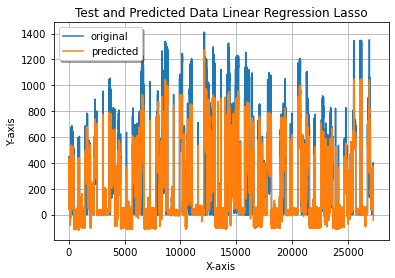

In [16]:
plot_true_vs_pred("Linear Regression Lasso", lr_test_y, lr_3_preds)

# Decision Tree 1

#### Decision tree predictor. Grid search cross validation on decision tree max depths 1-50. No need to standardize data for trees.

#### Set features and targets

In [17]:
# I found using 'HOUR' rather than 'TIME' results in higher accuracy in this case.
tree_1_features = ["PLANT_ID", "SOURCE_KEY", "AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE", "IRRADIATION", "HOUR"]

# Train data
tree_1_train_x = train_df_norm[tree_1_features]
tree_1_train_y = train_df_norm.AC_POWER

# One-hot-encode categories
tree_1_train_x.PLANT_ID = tree_1_train_x.PLANT_ID.astype("category")
tree_1_train_x.HOUR = tree_1_train_x.HOUR.astype("category")
tree_1_train_x = pd.get_dummies(tree_1_train_x)


# Test data
tree_1_test_x = test_df_norm[tree_1_features]
tree_1_test_y = test_df_norm.AC_POWER

# One-hot-encode categories
tree_1_test_x.PLANT_ID = tree_1_test_x.PLANT_ID.astype("category")
tree_1_test_x.HOUR = tree_1_test_x.HOUR.astype("category")


tree_1_test_x = pd.get_dummies(tree_1_test_x)

/var/folders/zb/s1317_1x2297w3nfdlpmclw40000gn/T/ipykernel_27812/2276981403.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree_1_train_x.PLANT_ID = tree_1_train_x.PLANT_ID.astype("category")
/var/folders/zb/s1317_1x2297w3nfdlpmclw40000gn/T/ipykernel_27812/2276981403.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tree_1_train_x.HOUR = tree_1_train_x.HOUR.astype("category")
/var/folders/zb/s1317_1x2297w3nfdlpmclw40000gn/T/ipykernel_27812/2276981403.py:19: SettingWithCopyWarning: 
A value is trying

In [18]:
dt_1_parameters = {'max_depth': range(1,50)}
dt_1 = GridSearchCV(DecisionTreeRegressor(random_state=100), 
                    dt_1_parameters, 
                    return_train_score=True,
                    verbose=3,
                    scoring='neg_mean_squared_error', 
                    n_jobs=-1)

dt_1.fit(tree_1_train_x, tree_1_train_y)
print("Optimal decision best parameters: ", dt_1.best_params_)

Fitting 5 folds for each of 49 candidates, totalling 245 fits
Optimal decision best parameters:  {'max_depth': 8}


In [19]:
dt_1_preds = dt_1.predict(tree_1_test_x)
calculate_metrics("Decision Tree 1", tree_1_test_y, dt_1_preds)

Decision Tree 1 MAE: 38.641551626739655 kW.
Decision Tree 1 RMSE: 125.1134962113933 kW.


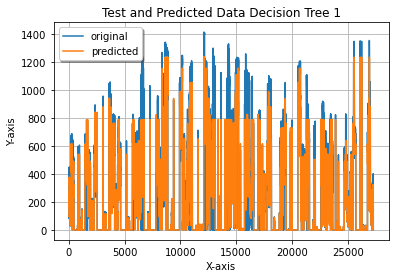

In [20]:
plot_true_vs_pred("Decision Tree 1", tree_1_test_y, dt_1_preds)

In [21]:
feature_importances = pd.Series(dt_1.best_estimator_.feature_importances_, 
                               index=tree_1_train_x.columns)
print("Feature importance:")
feature_importances.sort_values(ascending=False)[:25]

Feature importance:


IRRADIATION                   0.951054
PLANT_ID_4135001              0.025499
AMBIENT_TEMPERATURE           0.004129
SOURCE_KEY_Quc1TzYxW2pYoWX    0.003806
SOURCE_KEY_LYwnQax7tkwH5Cb    0.003563
SOURCE_KEY_Et9kgGMDl729KT4    0.003155
SOURCE_KEY_rrq4fwE8jgrTyWY    0.002735
SOURCE_KEY_q49J1IKaHRwDQnt    0.001870
MODULE_TEMPERATURE            0.001825
HOUR_9                        0.000472
HOUR_8                        0.000318
SOURCE_KEY_bvBOhCH3iADSZry    0.000270
HOUR_7                        0.000253
HOUR_16                       0.000222
HOUR_13                       0.000196
HOUR_14                       0.000139
SOURCE_KEY_1BY6WEcLGh8j5v7    0.000114
PLANT_ID_4136001              0.000106
HOUR_12                       0.000098
HOUR_11                       0.000060
SOURCE_KEY_WcxssY2VbP4hApt    0.000034
SOURCE_KEY_z9Y9gH1T5YWrNuG    0.000023
SOURCE_KEY_81aHJ1q11NBPMrL    0.000019
SOURCE_KEY_3PZuoBAID5Wc2HD    0.000010
SOURCE_KEY_WRmjgnKYAwPKWDb    0.000010
dtype: float64

In [22]:
dot_data = export_graphviz(dt_1.best_estimator_,
                          out_file=None,
                          feature_names=tree_1_train_x.columns,
                          proportion=True,
                          impurity=True,
                          filled=True,
                          rounded=True)
graph = graphviz.Source(dot_data)
graph.render('decision_tree_1_viz')

'decision_tree_1_viz.pdf'

<AxesSubplot:xlabel='depth'>

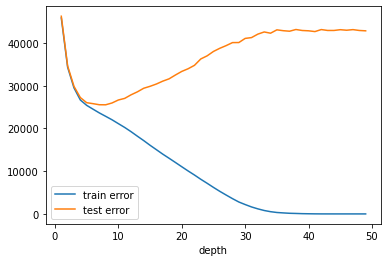

In [23]:
results = pd.DataFrame()
results['depth'] = dt_1_parameters['max_depth']
results['train error'] = 1 - dt_1.cv_results_['mean_train_score']
results['test error'] = 1 -  dt_1.cv_results_['mean_test_score']
ax1 = results.plot.line(x='depth', y='train error')
results.plot.line(x='depth', y='test error', ax=ax1)

# Random Forest

#### Radom forest predictor.

In [24]:
#rf_params = {'max_depth': np.arange(5, 50, 5), 'n_estimators':np.arange(5, 200, 5)}
#rf_params = {'max_depth': np.arange(5, 10, 5), 'n_estimators':np.arange(5, 10, 5)}
#rf_params = {'max_depth': np.arange(5, 50, 5), 'n_estimators':np.arange(5, 30, 5)}
rf_params = {'max_depth': np.arange(1, 14, 1), 'n_estimators':np.arange(1, 20, 1)}

rfCV = GridSearchCV(RandomForestRegressor(random_state=1), rf_params, 
                    return_train_score=True, 
                    scoring='neg_mean_squared_error', 
                    verbose=1, 
                    n_jobs=-1)

start = time.time()
rfCV.fit(tree_1_train_x, tree_1_train_y)
end = time.time()
print(str((end - start)/60) + " minutes to train random forest.")

print('Random Forest Regresor:')
print(' Optimal Parameters:', rfCV.best_params_)
print(' Optimal test R2:', rfCV.best_score_.round(3))

Fitting 5 folds for each of 247 candidates, totalling 1235 fits
3.1772117018699646 minutes to train random forest.
Random Forest Regresor:
 Optimal Parameters: {'max_depth': 9, 'n_estimators': 6}
 Optimal test R2: -24938.875


In [25]:
rf_preds = rfCV.predict(tree_1_test_x)
calculate_metrics("Random Forest", tree_1_test_y, rf_preds)

Random Forest MAE: 38.28671025499484 kW.
Random Forest RMSE: 125.5524491187381 kW.


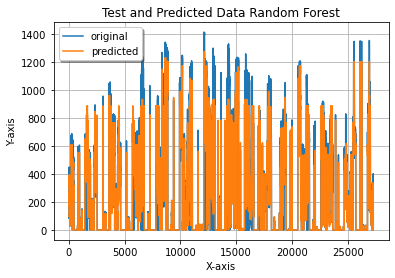

In [26]:
plot_true_vs_pred("Random Forest", tree_1_test_y, rf_preds)

In [27]:
feature_importances = pd.Series(rfCV.best_estimator_.feature_importances_, 
                               index=tree_1_train_x.columns)
print("Feature importance:")
feature_importances.sort_values(ascending=False)[:25]

Feature importance:


IRRADIATION                   0.944915
PLANT_ID_4135001              0.017059
PLANT_ID_4136001              0.008826
AMBIENT_TEMPERATURE           0.006086
SOURCE_KEY_Quc1TzYxW2pYoWX    0.003706
SOURCE_KEY_LYwnQax7tkwH5Cb    0.003703
MODULE_TEMPERATURE            0.003492
SOURCE_KEY_Et9kgGMDl729KT4    0.002997
SOURCE_KEY_rrq4fwE8jgrTyWY    0.002878
SOURCE_KEY_q49J1IKaHRwDQnt    0.001552
SOURCE_KEY_81aHJ1q11NBPMrL    0.000898
SOURCE_KEY_IQ2d7wF4YD8zU1Q    0.000686
HOUR_11                       0.000392
HOUR_13                       0.000373
HOUR_9                        0.000318
SOURCE_KEY_bvBOhCH3iADSZry    0.000266
HOUR_7                        0.000258
SOURCE_KEY_1BY6WEcLGh8j5v7    0.000242
HOUR_14                       0.000235
SOURCE_KEY_xMbIugepa2P7lBB    0.000212
HOUR_12                       0.000160
HOUR_8                        0.000158
SOURCE_KEY_WcxssY2VbP4hApt    0.000070
SOURCE_KEY_PeE6FRyGXUgsRhN    0.000062
HOUR_10                       0.000059
dtype: float64

# Gradient Boosting Trees

#### Gradient boosting tree predictors.

In [28]:
#gb_params = {'max_depth': np.arange(5, 50, 5), 'n_estimators':np.arange(5, 200, 5)}
gb_params = {'max_depth': np.arange(5, 10, 5), 'n_estimators':np.arange(5, 10, 5)}
#gb_params = {'max_depth': np.arange(1, 12, 1), 'n_estimators':np.arange(1, 16, 1)}

gbtCV = GridSearchCV(GradientBoostingRegressor(learning_rate=0.56, random_state=1), gb_params, 
                     return_train_score=True, 
                     scoring='neg_mean_squared_error', 
                     verbose=1, 
                     n_jobs=-1)

start = time.time()
gbtCV.fit(tree_1_train_x, tree_1_train_y)
end = time.time()
print(str((end - start)/60) + " minutes to train gradient boosting trees.")

print('Random Forest Regresor:')
print(' Optimal Parameters:', gbtCV.best_params_)
print(' Optimal test R2:', gbtCV.best_score_.round(3))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.028373301029205322 minutes to train gradient boosting trees.
Random Forest Regresor:
 Optimal Parameters: {'max_depth': 5, 'n_estimators': 5}
 Optimal test R2: -24884.47


In [29]:
gbt_preds = gbtCV.predict(tree_1_test_x)
calculate_metrics("Gradient Boosting", tree_1_test_y, gbt_preds)

Gradient Boosting MAE: 42.37410287288638 kW.
Gradient Boosting RMSE: 123.33235876757209 kW.


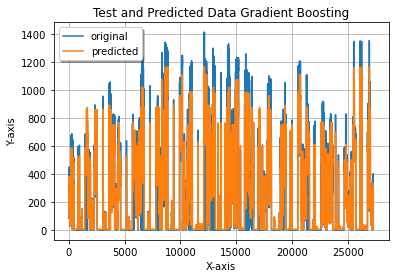

In [30]:
plot_true_vs_pred("Gradient Boosting", tree_1_test_y, gbt_preds)

In [31]:
feature_importances = pd.Series(rfCV.best_estimator_.feature_importances_, 
                               index=tree_1_train_x.columns)
print("Feature importance:")
feature_importances.sort_values(ascending=False)[:25]

Feature importance:


IRRADIATION                   0.944915
PLANT_ID_4135001              0.017059
PLANT_ID_4136001              0.008826
AMBIENT_TEMPERATURE           0.006086
SOURCE_KEY_Quc1TzYxW2pYoWX    0.003706
SOURCE_KEY_LYwnQax7tkwH5Cb    0.003703
MODULE_TEMPERATURE            0.003492
SOURCE_KEY_Et9kgGMDl729KT4    0.002997
SOURCE_KEY_rrq4fwE8jgrTyWY    0.002878
SOURCE_KEY_q49J1IKaHRwDQnt    0.001552
SOURCE_KEY_81aHJ1q11NBPMrL    0.000898
SOURCE_KEY_IQ2d7wF4YD8zU1Q    0.000686
HOUR_11                       0.000392
HOUR_13                       0.000373
HOUR_9                        0.000318
SOURCE_KEY_bvBOhCH3iADSZry    0.000266
HOUR_7                        0.000258
SOURCE_KEY_1BY6WEcLGh8j5v7    0.000242
HOUR_14                       0.000235
SOURCE_KEY_xMbIugepa2P7lBB    0.000212
HOUR_12                       0.000160
HOUR_8                        0.000158
SOURCE_KEY_WcxssY2VbP4hApt    0.000070
SOURCE_KEY_PeE6FRyGXUgsRhN    0.000062
HOUR_10                       0.000059
dtype: float64

# Feed Forward Neural Network 1

#### FF neural network predictor.

In [6]:
def plot_history(history):
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xticks(range(0, len(history['loss'] + 1)))
    plt.plot(history['loss'], label="training", marker='o')
    plt.plot(history['val_loss'], label="validation", marker='o')
    plt.legend()
    plt.show()
    
def build_model(lr=0.0001):
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)
    
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='relu'))

    model.compile(
        loss='mse',
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model

Metal device set to: Apple M1 Max
Epoch 1/20


2022-07-11 20:10:50.063293: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-11 20:10:50.063560: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-07-11 20:10:50.212538: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


   8/1536 [..............................] - ETA: 12s - loss: 272791.7500 - root_mean_squared_error: 522.2947 

2022-07-11 20:10:50.422817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1536/1536 [==============================] - ETA: 0s - loss: 34950.0000 - root_mean_squared_error: 186.9492

2022-07-11 20:11:00.285154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1536/1536 [==============================] - 11s 7ms/step - loss: 34950.0000 - root_mean_squared_error: 186.9492 - val_loss: 16336.7441 - val_root_mean_squared_error: 127.8153
Epoch 2/20
1536/1536 [==============================] - 10s 6ms/step - loss: 24303.8789 - root_mean_squared_error: 155.8970 - val_loss: 14525.5693 - val_root_mean_squared_error: 120.5221
Epoch 3/20
1536/1536 [==============================] - 10s 7ms/step - loss: 23713.1504 - root_mean_squared_error: 153.9908 - val_loss: 14933.1875 - val_root_mean_squared_error: 122.2014
Epoch 4/20
1536/1536 [==============================] - 10s 6ms/step - loss: 23436.0508 - root_mean_squared_error: 153.0884 - val_loss: 14310.1387 - val_root_mean_squared_error: 119.6250
Epoch 5/20
1536/1536 [==============================] - 10s 6ms/step - loss: 23238.2500 - root_mean_squared_error: 152.4410 - val_loss: 14553.8916 - val_root_mean_squared_error: 120.6395
Epoch 6/20
1536/1536 [==============================] - 10s 7ms/step - loss:

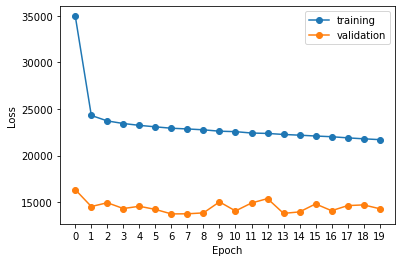

In [7]:
model_path = "./NeuralNets/Jacob/FFNN1/"

ffnn1 = build_model(lr=0.001)
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_path + "{epoch:02d}-{val_loss:.3f}", 
                                                monitor='val_loss', 
                                                save_best_only=True,
                                                save_weights_only=False, 
                                                mode='max', verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

history = ffnn1.fit(
  x = lr_train_x,  
  y = lr_train_y,         
  epochs=20,             
  batch_size=64,
  #callbacks=[checkpoint, earlystopping],
  validation_split=0.1, 
  verbose=1             
  )

history = pd.DataFrame(history.history)
plot_history(history)

In [8]:
# Load the best model
# files = os.listdir(model_path)
# paths = [os.path.join(model_path, basename) for basename in files if basename != "trainHistoryDict"]
# newestModelPath = max(paths, key=os.path.getctime)

# ffnn1 = tf.keras.models.load_model(newestModelPath)

# Evaluate
ffnn1_preds = ffnn1.predict(lr_test_x)
calculate_metrics("FFNN 1", lr_test_y, ffnn1_preds)

2022-07-11 20:14:15.479219: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


FFNN 1 MAE: 47.571068383399826 kW.
FFNN 1 RMSE: 132.39492205759163 kW.


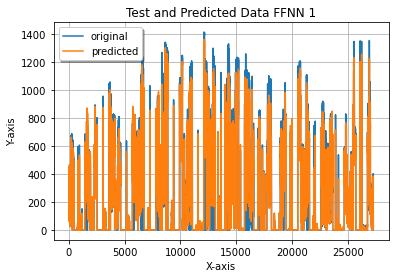

In [9]:
plot_true_vs_pred("FFNN 1", lr_test_y, ffnn1_preds)

# Results

In [36]:
model_results_df = pd.DataFrame([mae_results, rmse_results]).T
model_results_df.columns = ["MAE", "RMSE"]
model_results_df.sort_values(by='MAE', ascending=True)

,MAE,RMSE
Random Forest,38.286710,125.552449
Decision Tree 1,38.641552,125.113496
Gradient Boosting,42.374103,123.332359
FFNN 1,48.658158,136.641319
Linear Regression 1,78.700720,138.339576
Linear Regression Ridge,78.937520,138.372288
Linear Regression Lasso,79.032171,138.445598
Baseline,289.374273,329.970797


[CV 1/5] END max_depth=1;, score=(train=-47623.313, test=-39146.522) total time=   0.1s
[CV 1/5] END max_depth=3;, score=(train=-30326.462, test=-26526.618) total time=   0.1s
[CV 1/5] END max_depth=5;, score=(train=-26189.813, test=-22716.867) total time=   0.2s
[CV 2/5] END max_depth=7;, score=(train=-21315.422, test=-34571.297) total time=   0.2s
[CV 2/5] END max_depth=9;, score=(train=-19740.674, test=-35677.797) total time=   0.2s
[CV 1/5] END max_depth=11;, score=(train=-20908.267, test=-23765.443) total time=   0.3s
[CV 2/5] END max_depth=13;, score=(train=-16618.083, test=-38307.480) total time=   0.3s
[CV 1/5] END max_depth=15;, score=(train=-15944.697, test=-26528.497) total time=   0.3s
[CV 1/5] END max_depth=17;, score=(train=-13304.037, test=-28473.987) total time=   0.3s
[CV 2/5] END max_depth=19;, score=(train=-11943.579, test=-43672.596) total time=   0.3s
[CV 2/5] END max_depth=21;, score=(train=-10225.831, test=-46487.150) total time=   0.3s
[CV 5/5] END max_depth=22;

[CV 2/5] END max_depth=1;, score=(train=-42714.739, test=-59190.456) total time=   0.1s
[CV 3/5] END max_depth=3;, score=(train=-30680.020, test=-25001.569) total time=   0.1s
[CV 2/5] END max_depth=5;, score=(train=-23077.859, test=-35529.474) total time=   0.2s
[CV 1/5] END max_depth=7;, score=(train=-24414.251, test=-22434.027) total time=   0.2s
[CV 1/5] END max_depth=9;, score=(train=-22849.023, test=-22574.635) total time=   0.2s
[CV 2/5] END max_depth=11;, score=(train=-18191.867, test=-37062.770) total time=   0.3s
[CV 1/5] END max_depth=13;, score=(train=-18512.684, test=-25490.710) total time=   0.3s
[CV 5/5] END max_depth=14;, score=(train=-16895.076, test=-30669.813) total time=   0.3s
[CV 2/5] END max_depth=17;, score=(train=-13530.410, test=-41299.241) total time=   0.3s
[CV 1/5] END max_depth=19;, score=(train=-10634.878, test=-30091.520) total time=   0.3s
[CV 5/5] END max_depth=20;, score=(train=-11830.951, test=-33582.893) total time=   0.4s
[CV 1/5] END max_depth=23;

[CV 4/5] END max_depth=1;, score=(train=-47547.416, test=-39606.826) total time=   0.1s
[CV 5/5] END max_depth=3;, score=(train=-28121.831, test=-35668.747) total time=   0.1s
[CV 3/5] END max_depth=5;, score=(train=-26555.329, test=-21386.035) total time=   0.2s
[CV 3/5] END max_depth=7;, score=(train=-24419.804, test=-22348.043) total time=   0.2s
[CV 3/5] END max_depth=9;, score=(train=-22520.695, test=-23673.798) total time=   0.3s
[CV 4/5] END max_depth=11;, score=(train=-21817.557, test=-19642.666) total time=   0.3s
[CV 3/5] END max_depth=13;, score=(train=-18445.683, test=-27510.873) total time=   0.3s
[CV 3/5] END max_depth=15;, score=(train=-15991.067, test=-29572.657) total time=   0.3s
[CV 3/5] END max_depth=17;, score=(train=-13738.876, test=-30674.080) total time=   0.3s
[CV 3/5] END max_depth=19;, score=(train=-11514.083, test=-32930.212) total time=   0.3s
[CV 3/5] END max_depth=21;, score=(train=-9247.753, test=-34216.315) total time=   0.4s
[CV 3/5] END max_depth=23;,